#Deteksi Spam

##Import library dan Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Importi library dasat untuk visualiasasi data, pengoperasian mtk, mengolah data, dan membangun AI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

#import library untuk preprocessing data
import string
import plotly.express as px
import tensorflow.data as tfd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# utk membangun model
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
from tensorflow.keras import Model, layers

# Import WordCloud utk visualisasi teks
from wordcloud import WordCloud

# Import NLTK utk NLP
import nltk
from nltk.corpus import stopwords    # utk stopword


# Download NLTK data
nltk.download('stopwords')   # Download stopwords data
nltk.download('punkt')       # Download tokenizer data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive # upload dari google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle #membuat direktori kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/ #menyalin file kaggle.json dari gdrive
!chmod 600 ~/.kaggle/kaggle.json #memberikan izin file kepada pengguna agar dapat membaca dan menulis

In [ ]:
!kaggle datasets download -d team-ai/spam-text-message-classification #upload data dari kaglle

Dataset URL: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification
License(s): CC0-1.0
  0% 0.00/208k [00:00<?, ?B/s]
100% 208k/208k [00:00<00:00, 126MB/s]


In [ ]:
!unzip spam-text-message-classification.zip #ekstrak dataset

Archive:  spam-text-message-classification.zip
  inflating: SPAM text message 20170820 - Data.csv  


##Eksplorasi dan Preprocessing Data

###Eksplorasi Awal Dataset

In [ ]:
data = pd.read_csv("SPAM text message 20170820 - Data.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#Menampilkan Info  data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
data.columns

Index(['Category', 'Message'], dtype='object')

In [ ]:
# Menghitung jumlah setiap kategori dan mendapatkan nama kategorinya
class_dis = data.Category.value_counts()
class_names = class_dis.index

# Membuat Pie Chart
fig = px.pie(names=class_names, values=class_dis, title='Distribusi Kelas Pesan Spam')

# Menampilkan plot
fig.show()

In [ ]:
# Data set size
N_SAMPLES = len(data)

print(f"Total Number of Samples : {N_SAMPLES}")

Total Number of Samples : 5572


In [ ]:
data.isnull().sum() #Mengecek data yang kosong

Category    0
Message     0
dtype: int64

In [ ]:
data.duplicated().sum() #Mengecek data yang sama

415

In [ ]:
#Menghapus data duplikat
delete_duplicates = data.drop_duplicates()
df = delete_duplicates

df.duplicated().sum()

0

In [ ]:
#Mencari panjang maksimum dari data
max_len = max([len(text) for text in data.Message])
print(f"Maximum Length Of Input Sequence(Chars) : {max_len}")

Maximum Length Of Input Sequence(Chars) : 910


###Pre-Processing Data

In [ ]:
# mendefinisikan hyperparameters
num_heads = 4
embed_dim = 256
ff_dim = 128
vocab_size = 10000
max_seq_len = 40

In [ ]:
# Extract X and y from the data frame
X = data['Message'].tolist()
y = data['Category'].tolist()

In [ ]:
# Label Encoding untuk konversi label teks menjadi nilai numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
print(f'X[:5]: \n{X[:5]}\n')
print(f'y[:5]: {y[:5]}\n')
print(f"Label Mapping : {label_encoder.inverse_transform(y[:5])}")

X[:5]: 
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though"]

y[:5]: [0 0 1 0 0]

Label Mapping : ['ham' 'ham' 'spam' 'ham' 'ham']


In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=data.Category.unique(), y=label_encoder.inverse_transform(y))
class_weights = {number: weight for number, weight in enumerate(class_weights)}
# Show
print(f"Associated class weights: {class_weights}")

Associated class weights: {0: 0.5774093264248704, 1: 3.7295850066934406}


In [ ]:
# Mendefinisikan fungsi untuk memproses teks
def preprocess_text(text: str) -> str:
    text = tf.strings.regex_replace(text, f"[{string.punctuation}]", " ")
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    return text

# Membuat lapisan TextVectorization
text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_seq_len,
    standardize=preprocess_text,
    output_mode='int'
)

# Menyesuaikan lapisan TextVectorization ke data
text_vectorizer.adapt(X)

In [ ]:
for _ in range(5):
    # Pilih teks secara acak
    text_temp = X[np.random.randint(N_SAMPLES)]

    # Vektorisasi teks
    text_vec_temp = text_vectorizer(text_temp)

    # Tampilkan hasil
    print(f"Teks Asli: {text_temp}")
    print(f"Teks Vektorisasi: {text_vec_temp}\n")

Teks Asli: FreeMsg: Fancy a flirt? Reply DATE now & join the UKs fastest growing mobile dating service. Msgs rcvd just 25p to optout txt stop to 83021. Reply DATE now!
Teks Vektorisasi: [ 813  816    5 1421   98  590   23  478    6 2345 3811 3730  101  698
  228  689 1222   41 1302    3 1766   77   90    3 8422   98  590   23
    0    0    0    0    0    0    0    0    0    0    0    0]

Teks Asli: Misplaced your number and was sending texts to your old number. Wondering why i've not heard from you this year. All the best in your mcat. Got this number from my atlanta friends
Teks Vektorisasi: [6250   15  150    8   65  898  458    3   15  609  150 1093  170    2
  153   29  916   52    4   43  268   55    6  280    9   15 3520   62
   43  150   52   12 2227  251    0    0    0    0    0    0]

Teks Asli: Havent planning to buy later. I check already lido only got 530 show in e afternoon. U finish work already?
Teks Vektorisasi: [ 521 1227    3  205  108    2  334  159 2600   71   62 19

In [ ]:
# lihat jumlah kata
VOCAB = text_vectorizer.get_vocabulary()

# Tokenisasi vocabulary
print(f"Vocabulary size: {len(VOCAB)}")
print(f"Vocabulary: {VOCAB[150:200]}")

Vocabulary size: 8841
Vocabulary: ['number', 'message', 'e', 've', 'tomorrow', 'say', 'won', 'right', 'prize', 'already', 'after', 'said', 'ask', 'doing', 'cash', 'amp', '3', 'yeah', 'really', 'im', 'why', 'b', 'life', 'them', 'meet', 'find', 'very', 'miss', 'morning', 'let', 'babe', 'last', 'would', 'win', 'thanks', 'cos', 'anything', 'uk', 'lol', 'also', 'care', 'every', 'sure', 'pick', 'com', '150p', 'sent', 'nokia', 'keep', 'urgent']


##Pemodelan Tensorflow-Text (Transformer)

###Split data

In [ ]:
# membagi data menjadi 80 persen  training dan 20 persen testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Memasukan textnya
X_train = text_vectorizer(X_train)
X_test = text_vectorizer(X_test)

# One Hot Vectors
Xoh_train = tf.one_hot(X_train, depth=10000)
Xoh_test  = tf.one_hot(X_test, depth=10000)

In [ ]:
class TokenAndPositionalEmbedding(layers.Layer):

    def __init__(self, embedding_dims, vocab_size, seq_len, **kwargs):
        super(TokenAndPositionalEmbedding, self).__init__(**kwargs)

        # Initialize parameters
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embedding_dims = embedding_dims
        self.embed_scale = tf.math.sqrt(tf.cast(embedding_dims, tf.float32))

        # Define layers
        self.token_embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dims,
            name="token_embedding"
        )

        self.positional_embedding = layers.Embedding(
            input_dim=seq_len,
            output_dim=embedding_dims,
            name="positional_embedding"
        )

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]

        # Token Embedding
        token_embedding = self.token_embedding(inputs)
        token_embedding *= self.embed_scale

        # Positional Embedding
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_embedding = self.positional_embedding(positions)

        # Add Token and Positional Embedding
        embeddings = token_embedding + positional_embedding

        return embeddings


    def get_config(self):
        config = super(TokenAndPositionalEmbedding, self).get_config()
        config.update({
            'embedding_dims': self.embedding_dims,
            'vocab_size': self.vocab_size,
            'seq_len': self.seq_len,
        })
        return config

In [ ]:
# Let's look what the layer do.
temp_embeds = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len)(X_train[:1])
temp_embeds

<tf.Tensor: shape=(1, 40, 256), dtype=float32, numpy=
array([[[ 0.42701313,  0.4213275 , -0.08589311, ..., -0.20346317,
          0.34488827,  0.48532376],
        [-0.71295494,  0.39563066,  0.71222806, ...,  0.1163729 ,
         -0.01581598, -0.19061086],
        [ 0.4161461 ,  0.6321135 ,  0.3369141 , ..., -0.2286785 ,
          0.2183489 ,  0.72127527],
        ...,
        [-0.2658375 ,  0.22820011, -0.5251519 , ..., -0.72405213,
          0.05362446,  0.6890844 ],
        [-0.2669791 ,  0.24140956, -0.5198953 , ..., -0.667406  ,
          0.10150231,  0.6745428 ],
        [-0.20344603,  0.28531846, -0.51985806, ..., -0.68102324,
          0.10407382,  0.7343206 ]]], dtype=float32)>

###Transformer Layer

In [ ]:
# mengatur parameter
learning_rate = 1e-3
epochs = 100
batch_size = 32

# mendefinisikan callbacks pelatihan
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("SpamDetector.h5", save_best_only=True)
]

In [ ]:
class TransformerLayer(layers.Layer):

    def __init__(self, num_heads: int, dropout_rate: float, embedding_dims: int, ff_dim: int, **kwargs):
        super(TransformerLayer, self).__init__(**kwargs)

        # Initialize Parameters
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.embedding_dims = embedding_dims
        self.ff_dim = ff_dim

        # Initialize Layers
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims, dropout=dropout_rate)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(embedding_dims)
        ])
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        """Forward pass of the Transformer Layer.

        Args:
            inputs: Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the input sequence.

        Returns:
            Tensor with shape `(batch_size, seq_len, embedding_dims)` representing the output sequence after applying the Transformer Layer.
        """

        # Multi-Head Attention
        attention = self.mha(inputs, inputs, inputs)

        # Layer Normalization and Residual Connection
        normalized1 = self.ln1(attention + inputs)

        # Feedforward Network
        ffn_out = self.ffn(normalized1)

        # Layer Normalization and Residual Connection
        normalized2 = self.ln2(ffn_out + normalized1)

        return normalized2

    def get_config(self):
        """Get the configuration of the Transformer Layer.

        Returns:
            Dictionary with the configuration of the layer.
        """
        config = super(TransformerLayer, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
            "embedding_dims": self.embedding_dims,
            "ff_dim": self.ff_dim
        })
        return config

In [ ]:
# Transformer layers execution
TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1)(temp_embeds)

<tf.Tensor: shape=(1, 40, 256), dtype=float32, numpy=
array([[[ 1.5215577 ,  0.5836963 ,  0.69941616, ..., -0.02216428,
          1.1481253 , -0.38346034],
        [-0.88385886,  0.4789825 ,  1.2988936 , ...,  0.4527012 ,
          0.5106449 , -0.9604075 ],
        [ 1.1046493 ,  1.3250263 ,  1.2325991 , ..., -0.17123042,
          0.07096004,  0.73494446],
        ...,
        [-0.80673724, -0.39087158,  0.0852903 , ..., -1.2774311 ,
          0.02626222,  0.3712698 ],
        [-0.7430371 , -0.42698485,  0.1014016 , ..., -1.2234442 ,
          0.07875717,  0.29534978],
        [-0.65858626, -0.28658515,  0.15879935, ..., -1.3105134 ,
          0.16795118,  0.50800925]]], dtype=float32)>

###Model

In [ ]:
# Input layer
InputLayer = layers.Input(shape=(max_seq_len,), name="InputLayer")

# Embedding Layer
embeddings = TokenAndPositionalEmbedding(embed_dim, vocab_size, max_seq_len, name="EmbeddingLayer")(InputLayer)

# Transformer Layer
encodings = TransformerLayer(num_heads=num_heads, embedding_dims=embed_dim, ff_dim=ff_dim, dropout_rate=0.1, name="TransformerLayer")(embeddings)

# Classifier
gap = layers.GlobalAveragePooling1D(name="GlobalAveragePooling")(encodings)
drop = layers.Dropout(0.5, name="Dropout")(gap)
OutputLayer = layers.Dense(1, activation='sigmoid', name="OutputLayer")(drop)

# Model
model = keras.Model(InputLayer, OutputLayer, name="TransformerNet")

# Model Architecture Summary
model.summary()

Model: "TransformerNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 40)]              0         
                                                                 
 EmbeddingLayer (TokenAndPo  (None, 40, 256)           2570240   
 sitionalEmbedding)                                              
                                                                 
 TransformerLayer (Transfor  (None, 40, 256)           1118848   
 merLayer)                                                       
                                                                 
 GlobalAveragePooling (Glob  (None, 256)               0         
 alAveragePooling1D)                                             
                                                                 
 Dropout (Dropout)           (None, 256)               0         
                                                    

##Pelatihan Model

In [ ]:
# Membuat Model Kompilasi
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]
)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
126/126 [==============================] - 21s 102ms/step - loss: 0.2126 - accuracy: 0.9265 - precision: 0.6620 - recall: 0.9036 - auc: 0.9722 - val_loss: 0.1029 - val_accuracy: 0.9776 - val_precision: 0.8933 - val_recall: 0.9710 - val_auc: 0.9851
Epoch 2/100
126/126 [==============================] - 5s 35ms/step - loss: 0.0319 - accuracy: 0.9940 - precision: 0.9685 - recall: 0.9868 - auc: 0.9986 - val_loss: 0.0579 - val_accuracy: 0.9888 - val_precision: 0.9848 - val_recall: 0.9420 - val_auc: 0.9868
Epoch 3/100
126/126 [==============================] - 2s 20ms/step - loss: 0.0052 - accuracy: 0.9990 - precision: 0.9925 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9888 - val_precision: 0.9848 - val_recall: 0.9420 - val_auc: 0.9825
Epoch 4/100
126/126 [==============================] - 3s 25ms/step - loss: 0.0015 - accuracy: 0.9998 - precision: 0.9981 - recall: 1.0000 - auc: 0.9999 - val_loss: 0.0548 - val_accuracy: 0.9910 - val_precision: 0.9851 - val

##Evaluasi Model

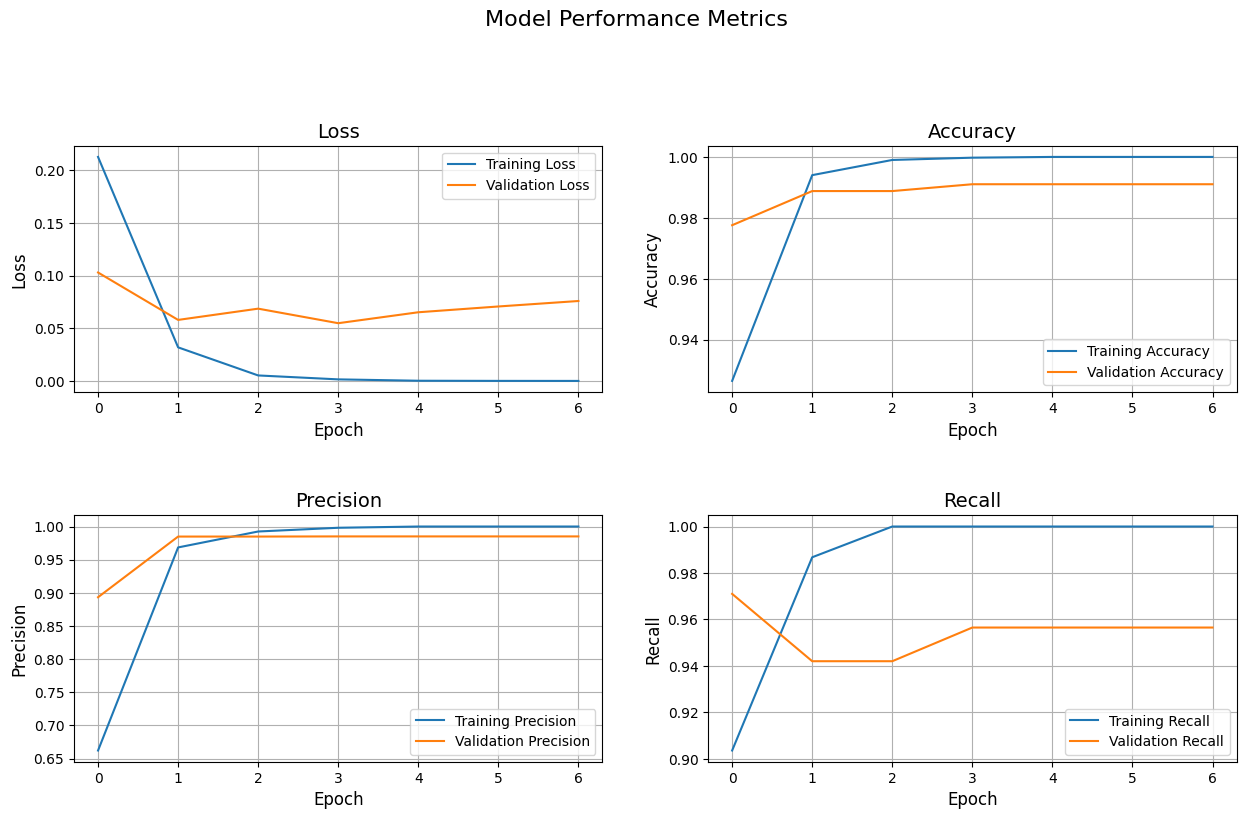

In [ ]:
# Plot metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].grid(True)
axes[0, 0].legend(fontsize=10)

axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].grid(True)
axes[0, 1].legend(fontsize=10)

axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].grid(True)
axes[1, 0].legend(fontsize=10)

axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].grid(True)
axes[1, 1].legend(fontsize=10)

fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)
plt.show()

In [ ]:
# Evaluate model performance on test data
loss, acc, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)

# Show the model performance
print('Test loss      :', loss)
print('Test accuracy  :', acc*100)
print('Test precision :', precision*100)
print('Test recall    :', recall*100)
print('Test AUC       :', auc*100)

Test loss      : 0.05603860691189766
Test accuracy  : 98.92376661300659
Test precision : 98.58155846595764
Test recall    : 93.28858852386475
Test AUC       : 97.90910482406616


##Analisis Hasil Prediksi

In [ ]:
def decode_tokens(tokens):
    """
    This function takes in a list of tokenized integers and returns the corresponding text based on the provided vocabulary.

    Args:
    - tokens: A list of integers representing tokenized text.
    - vocab: A list of words in the vocabulary corresponding to each integer index.

    Returns:
    - text: A string of decoded text.
    """
    text = " ".join(VOCAB[int(token)] for token in tokens).strip()
    return text

In [ ]:
for _ in range(10):
    # Randomly select a text from the testing data.
    index = np.random.randint(1,len(X_test))
    tokens = X_test[index-1:index]
    label = y_test[index]

    # Feed the tokens to the model
    print(f"\nModel Prediction\n{'-'*100}")
    proba = 1 if model.predict(tokens, verbose=0)[0][0]>0.5 else 0
    pred = label_encoder.inverse_transform([proba])
    print(f"Message: '{decode_tokens(tokens[0])}' | Prediction: {pred[0].title()} | True : {label_encoder.inverse_transform([label])[0].title()}\n")


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'todays voda numbers ending with 7634 are selected to receive a £350 reward if you have a match please call 08712300220 quoting claim code 7684 standard rates apply' | Prediction: Spam | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'he neva grumble but i sad lor hee buy tmr lor aft lunch but we still meetin 4 lunch tmr a not neva hear fr them lei Ü got a lot of work ar' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'alright i have a new goal now' | Prediction: Ham | True : Ham


Model Prediction
----------------------------------------------------------------------------------------------------
Message: 'like a personal sized or what' | Prediction: Ham | 

##Optimasi Parameter (Mengubah Parameter)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
from keras.metrics import Accuracy
from keras import utils
from keras import callbacks
from sklearn.model_selection import train_test_split
from absl import logging
logging.set_verbosity(logging.ERROR)  # ignore notification

In [ ]:
# Loading data
df = pd.read_csv('SPAM text message 20170820 - Data.csv')

In [ ]:
# Preprocessing data
df.replace('ham', 0, inplace=True)
df.replace('spam', 1, inplace=True)
df['Category'] = df['Category'].astype('int8')

In [ ]:
texts = df['Message']
labels = df['Category']

In [ ]:
NUM_WORDS = 10000
MAX_TEXT_LEN = 100

In [ ]:
# Tokenizer
lstm_tokenizer = Tokenizer(num_words=NUM_WORDS)
lstm_tokenizer.fit_on_texts(texts)  # training tokenizer

In [ ]:
# Get VOCAB from the tokenizer
VOCAB = lstm_tokenizer.index_word

In [ ]:
sequences = lstm_tokenizer.texts_to_sequences(texts)
lstm_X = pad_sequences(sequences, maxlen=MAX_TEXT_LEN)  # Standardization of the number of elements in a vector
lstm_y = labels.copy()

In [ ]:
# pembagian data test dan train
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(lstm_X, lstm_y, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
# Pembangunan Model
lstm_model = Sequential()
lstm_model.add(Embedding(NUM_WORDS, 64, input_length=MAX_TEXT_LEN))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 706113 (2.69 MB)
Trainable params: 706113 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

lstm_model.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adam')

In [ ]:
# melatih model
lstm_history = lstm_model.fit(lstm_X_train, lstm_y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 20s 238ms/step - loss: 0.2855 - accuracy: 0.9038 - val_loss: 0.1211 - val_accuracy: 0.9641
Epoch 2/10
56/56 [==============================] - 8s 145ms/step - loss: 0.0490 - accuracy: 0.9865 - val_loss: 0.0674 - val_accuracy: 0.9809
Epoch 3/10
56/56 [==============================] - 5s 92ms/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.0773 - val_accuracy: 0.9809
Epoch 4/10
56/56 [==============================] - 4s 73ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.0803 - val_accuracy: 0.9809
Epoch 5/10
56/56 [==============================] - 4s 68ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0903 - val_accuracy: 0.9809
Epoch 6/10
56/56 [==============================] - 2s 36ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0949 - val_accuracy: 0.9821
Epoch 7/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1033 - val_accuracy: 0.9798
Epoch 8/10

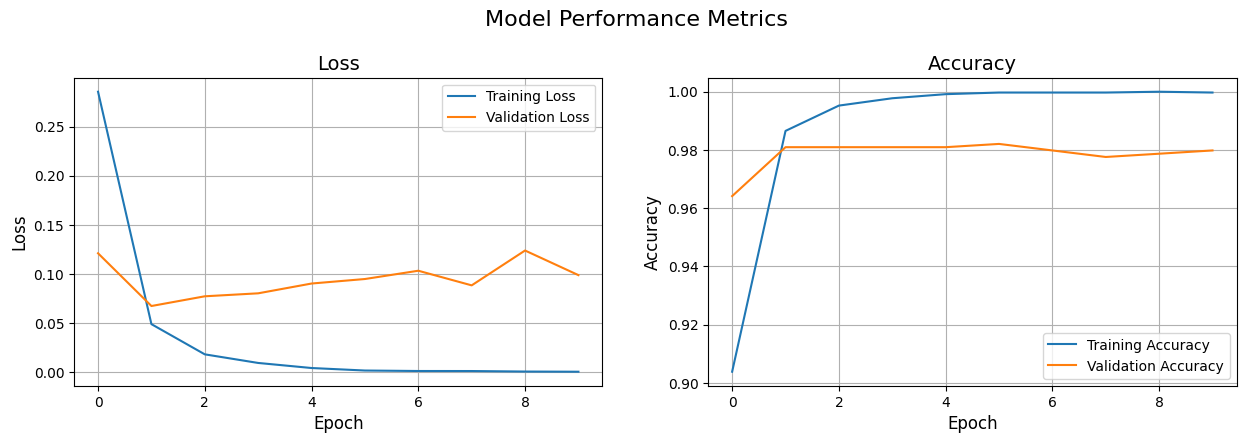

In [ ]:
# Visualisasi kan performa pembelajaran
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
plt.subplots_adjust(hspace=0.5)

axes[0].plot(lstm_history.history['loss'], label='Training Loss')
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True)
axes[0].legend(fontsize=10)

axes[1].plot(lstm_history.history['accuracy'], label='Training Accuracy')
axes[1].plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].grid(True)
axes[1].legend(fontsize=10)

fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)
plt.show()

In [ ]:
# Evaluate model performance on test data
test_loss, test_accuracy = lstm_model.evaluate(lstm_X_test, lstm_y_test)
print('Test loss      :', test_loss)
print('Test accuracy  :', test_accuracy)
loss, acc, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)


35/35 [==============================] - 0s 8ms/step - loss: 0.0714 - accuracy: 0.9821
Test loss      : 0.0714031383395195
Test accuracy  : 0.9820627570152283
